# Installs

In [ ]:
!pip install rouge-score
!pip uninstall -y wandb
!pip install openpyxl

# Libraries

In [ ]:
import re
import ast
import torch
import tokenizers
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, T5Tokenizer, MT5ForConditionalGeneration, MT5Tokenizer, EarlyStoppingCallback

# NER
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.charsets import AR_LETTERS_CHARSET
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.ner import NERecognizer
# POS tagging
# from camel_tools.morphology.disambiguator import Disambiguator


# Prepare the data for Train

## load data

In [ ]:
df_squad = pd.read_excel("/kaggle/input/arabic-squad-processed/Arabic_squad_data_processed.xlsx")

## load tokenizer

In [ ]:
tokenizer = tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

## T5 preparation

In [ ]:
def preprocess_dataset(dataset):
    preprocessed_data = []
    skip_counter = 0
    answer_skiped_counter = 0
    for example in dataset:
        
        # Skip empty examples
        if not example["processed_context"] or not example["processed_question"] or not example["processed_answers"]:
            skip_counter += 1
            continue

        # Tokenize the input (context)
        inputs = tokenizer(
            example["processed_context"],
            max_length=128,
            truncation=True,
            padding="max_length",
        )

        # # Ensure answers are not empty and get the first answer
        # if isinstance(example["processed_answers"], list) and example["processed_answers"]:
        #     answer_text = example["processed_answers"][0]
        # else:
        #     answer_skiped_counter += 1
        #     answer_text = ""
            
        # answer_text = example["processed_answers"][0] if isinstance(example["processed_answers"], list) and example["processed_answers"] else ""
        # answer_text = example["processed_answers"]
        # answer_text = ""
        
        # Combine question and answer for label (question generation + answer)
        question_answer_text = example["processed_question"]

        # Tokenize the target (question)
        labels = tokenizer(
            question_answer_text,
            max_length=128,
            truncation=True,
            padding="max_length",
        )

        # Append preprocessed data
        preprocessed_data.append({
            "input_ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels["input_ids"], dtype=torch.long),
        })
        
    print(skip_counter , " skiped due to empty")
    print(answer_skiped_counter , " answers skiped")
    return preprocessed_data


In [ ]:
# Split by context_id to avoid data leakage
context_ids = df_squad["c_id"].unique()
train_ids, test_ids = train_test_split(context_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Create splits
train_data = df_squad[df_squad["c_id"].isin(train_ids)].to_dict("records")
val_data = df_squad[df_squad["c_id"].isin(val_ids)].to_dict("records")
test_data = df_squad[df_squad["c_id"].isin(test_ids)].to_dict("records")

# Preprocess each split
train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)


print("total rows after processing ", len(train_processed) + len(val_processed) + len(test_processed))

In [ ]:
# c = 9
# print(df_squad["processed_context"][c])
# print(df_squad["processed_question"][c], " + ", df_squad["processed_answers"][c])
# print("--------------------------------")
# print(tokenizer.decode(train_processed[0]["input_ids"], skip_special_tokens=True))
# print(tokenizer.decode(train_processed[0]["labels"], skip_special_tokens=True))

In [ ]:
# # Check tokenization and decoding
# for i, example in enumerate(train_processed[:3], 1):
#     original_context = train_data[i - 1]["processed_context"]
#     input_ids = example["input_ids"]

#     # Decode using the correct tokenizer
#     decoded_context = tokenizer.decode(input_ids, skip_special_tokens=True)

#     print(f"Example {i}:")
#     print("Decoded Context:", decoded_context)
#     print("Original Context:", original_context)

#     if decoded_context == original_context:
#         print("The contexts match!")
#     else:
#         print("The contexts DO NOT match!")
#     print("-" * 50)


# Model

### Select a model

In [89]:
# model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small", ignore_mismatched_sizes=True)
# model = T5ForConditionalGeneration.from_pretrained("UBC-NLP/araT5-base")
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/arat5_base_final/pytorch/default/1")

### Change the size of the model to accept the tokens

In [47]:
# Resize the model's embedding layer
model.resize_token_embeddings(len(tokenizer))

# Verify the new vocabulary size
print("New model vocabulary size:", model.config.vocab_size)

New model vocabulary size: 110100


## check on data

In [ ]:
def check_tensor_dataset(dataset, name="Dataset"):
    print(f"Checking {name} for NaN or Inf values...")
    for i in range(len(dataset)):
        sample = dataset[i]  # Get one example (which is a dictionary)

        for key in ["input_ids", "attention_mask", "labels"]:
            if key in sample:
                tensor = sample[key]  # Extract tensor for this key

                if torch.isnan(tensor).any():
                    print(f"NaN found in {key} at index {i}")
                if torch.isinf(tensor).any():
                    print(f"Inf found in {key} at index {i}")

    print(f"Check complete for {name}.\n")

In [ ]:
check_tensor_dataset(train_data, "Training Dataset")

In [ ]:
check_tensor_dataset(val_data, "Validation Dataset")

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)  # Get predictions (argmax for classification)
    acc = accuracy_score(labels, preds)  # Compute accuracy
    return {"accuracy": acc}  # Return accuracy

## Train the model

In [ ]:
# Define training arguments
num_train_epochs = 5

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # gradient_accumulation_steps=4,    # Accumulate gradients over 4 steps
    num_train_epochs=num_train_epochs,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=False,
    fp16=False,
    dataloader_num_workers=2,  # we can increase the dataloader to 4 maybe
    # max_grad_norm=1.0,  # Clip gradients to prevent out-of-memory errors
)

# Create a Trainer instance with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_processed,
    eval_dataset=val_processed,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping callback
)

# Train the model with logging
print("Starting training...")
trainer.train()
print("Training completed.")


# Save model and tokenizer

## move model to cpu

In [ ]:
model.cpu()

## save the model

In [ ]:
model.save_pretrained("/kaggle/working/arat5_model_base_20")

## compress and download the model

In [ ]:
!zip -r /kaggle/working/arat5_model_base_20.zip /kaggle/working/arat5_model_base_20

In [ ]:
from IPython.display import FileLink
FileLink("/kaggle/working/mt5_model_small_2.zip")

## save the tokenizer

In [ ]:
tokenizer.save_pretrained("/kaggle/working/mt5_tokenizer")

# load model and tokenizer

## load the model

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/arat5_base_final/pytorch/default/1")

### move the model to cuda

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("Model loaded successfully on", device)

Model loaded successfully on cuda


## load the tokenizer

In [ ]:
# tokenizer = MT5Tokenizer.from_pretrained("/kaggle/input/mt5-tokenizer/pytorch/default/1")
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

# Test 

In [87]:
# After training, generate predictions:
input_context = 'ولد العالم العربي الشهير ابن الهيثم في مدينة البصرة عام 965 ميلادي. كان أحد أبرز العلماء في العصر الذهبي الإسلامي، حيث قدم مساهمات كبيرة في مجالات البصريات، والرياضيات، والهندسة، والفيزياء. يُعتبر كتابه "المناظر" من أهم الكتب التي أثرت في علم البصريات، حيث شرح فيه مبادئ الانعكاس والانكسار، ووضع أسس علم الضوء الحديث. بالإضافة إلى ذلك، كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي، إذ اعتمد على الملاحظة والتجربة لإثبات نظرياته. سافر إلى مصر بدعوة من الخليفة الفاطمي الحاكم بأمر الله، وهناك قام بدراسة سلوك الضوء في الماء والهواء.'

# Tokenize the context and move to the same device as the model
inputs = tokenizer(input_context, return_tensors="pt").to(device)

for i in range(4):
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=512,
            do_sample=True,
            num_beams=1,  # Disable beam search for more diversity
            early_stopping=True,
            top_p=0.8,  # Lower top_p for more diversity
            temperature=1.0,  # Higher temperature for more randomness
            num_return_sequences=4,
        )
    
    # Decode the output ids to text
    for j, output_id in enumerate(output_ids):
        generated_text = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"Generated Text {i+1}-{j+1}:", generated_text)

Generated Text 1-1: ماذا كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي؟
Generated Text 1-2: ما هو الكتاب الذي وضعه ابن الهيثم في علم البصريات؟
Generated Text 1-3: ما هو كتاب المناظر الذي قام ابن الهيثم بشرحه؟
Generated Text 1-4: ما هو أول كتاب وضعه ابن الهيثم؟
Generated Text 2-1: ما هو أول كتاب وضعه ابن الهيثم؟
Generated Text 2-2: ما الكتاب الذي وضعه ابن الهيثم في علم البصريات؟
Generated Text 2-3: في أي عام ولد ابن الهيثم؟
Generated Text 2-4: في أي عام ولد ابن الهيثم في البصرة؟
Generated Text 3-1: متى ولد العالم العربي الشهير ابن الهيثم؟
Generated Text 3-2: ما الكتاب الذي وضعه ابن الهيثم؟
Generated Text 3-3: ما الكتاب الذي كتب ابن الهيثم فيه؟
Generated Text 3-4: ما الكتاب الذي وضع أسس علم الضوء الحديث؟
Generated Text 4-1: ماذا كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي؟
Generated Text 4-2: ماذا قدم ابن الهيثم في مجال البصريات؟
Generated Text 4-3: أي كاتب من أهم الكتب التي أثرت في علم البصريات؟
Generated Text 4-4: كم عدد الكتب التي كتبها ابن الهيثم؟


In [162]:
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict

# Dummy grammar check (replace with a proper Arabic grammar checker if available)
def grammar_check(question):
    return 1 if question.strip().endswith("؟") and re.match(r"^(لما|ماذا|في|ما|كيف|لماذا|متى|أين|هل|من)", question.strip(), re.IGNORECASE) else 0

def normalize_text(text):
    return " ".join(text.strip().split())
    
# Grouping the labels (questions) by context
def group_labels_by_context(test_data):
    context_to_labels = defaultdict(list)  # Use a list to hold multiple questions per context
    for sample in test_data:
        # Decode the input_ids (context) to text
        context = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
        context = normalize_text(context)  # Normalize context for matching
        label = sample["labels"][0]  # Assuming labels contain a single question
        context_to_labels[context].append(label)
    return context_to_labels

# Coherence function with the correct handling of reference questions
def coherence_score_ar(question, ref_questions, tokenizer, model):
    if not ref_questions:  # If no reference questions, return a low score
        return 0.0

    # Ensure ref_questions contains strings
    ref_questions = [str(q) for q in ref_questions if isinstance(q, str) and q.strip()]

    if not ref_questions:  # If no valid reference questions after filtering, return a low score
        print("check again on ref questoins")
        return 0.0

    # Tokenize the input question and the reference questions
    question_tokens = tokenizer(question, return_tensors="pt", padding=True, truncation=True)
    
    # Tokenize reference questions
    ref_tokens = tokenizer(ref_questions, return_tensors="pt", padding=True, truncation=True)

    # Move tensors to the same device as the model
    device = next(model.parameters()).device
    question_tokens = {key: val.to(device) for key, val in question_tokens.items()}
    ref_tokens = {key: val.to(device) for key, val in ref_tokens.items()}

    # Generate embeddings for both the input question and reference questions
    with torch.no_grad():
        question_embedding = model.encoder(**question_tokens).last_hidden_state.mean(dim=1)
        ref_embeddings = model.encoder(**ref_tokens).last_hidden_state.mean(dim=1)

    # Compute cosine similarity between the input question and reference questions
    scores = util.pytorch_cos_sim(question_embedding, ref_embeddings)

    # Return the average similarity score
    return scores.mean().item()


# Readability: Approximate using word count
def readability_score_ar(question):
    word_count = len(question.split())
    return max(0, min(1, 10 / word_count))

def arabic_question_quality(question, context, context_to_labels, tokenizer, model):
    # Normalize the context before looking it up in the reference dictionary
    normalized_context = normalize_text(context)
    
    # Retrieve reference questions for this normalized context
    ref_questions = context_to_labels.get(normalized_context, [])
    
    if not ref_questions:  # If no reference questions, skip coherence evaluation
        print(f"Warning: No reference questions found for context '{normalized_context[:50]}...'")
    
    results = {
        "Grammar Score": grammar_check(question),
        "Coherence Score": coherence_score_ar(question, ref_questions, tokenizer, model),
        "Readability Score": readability_score_ar(question),
    }

    # Weighted final score
    final_score = (
        results["Grammar Score"] * 0.5 +
        results["Coherence Score"] * 0.4 +
        results["Readability Score"] * 0.1
    )

    results["Final Quality Score"] = final_score
    return results


In [163]:
# Process a subset of test_processed from index 20 to 40
subset_test_data = test_processed[20:40]

for sample_idx, sample in enumerate(subset_test_data):
    context = sample.get("context", "")  # Use .get() to avoid KeyError and default to an empty string

    # Ensure context is a string
    if not isinstance(context, str) or not context.strip():
        print(f"Skipping sample {sample_idx + 20} due to invalid context.")
        continue

    # Tokenize the context and move to the same device as the model
    inputs = tokenizer(context, return_tensors="pt", truncation=True, padding=True).to(device)

    print(f"\n=== Processing Sample {sample_idx + 20} ===")
    print(f"Context: {context}\n")

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=512,
            do_sample=True,
            num_beams=1,  # Disable beam search for more diversity
            early_stopping=True,
            top_p=0.7,  # Lower top_p for more diversity
            temperature=1.0,  # Higher temperature for more randomness
            num_return_sequences=4,
        )

    # Decode and evaluate each generated question
    for j, output_id in enumerate(output_ids):
        generated_text = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"Generated Question {j+1}:", generated_text)

        # Evaluate the quality of the generated question
        results = arabic_question_quality(generated_text, context, tokenizer, model)

        for metric, score in results.items():
            print(f"{metric}: {score:.2f}")
        print("------------------------------------------------------------------------")


questions gropued based on contexts

=== Processing Sample 20 ===
Decoded Context: تحدث مراحل مختلفة من الهضم بما في ذلك المرحلة الراسية المرحلة المعدية والمرحلة المعوية تحدث المرحلة الراسية عند رؤية الطعام وفكره ورائحته مما يحفز القشرة الدماغية يتم ارسال المنبهات والرائحة الى منطقة...

Generated Question 1: ما هو النشاط العصبي الذي يتم تشغيله في هذه المرحلة؟
check again on ref questoins
Grammar Score: 1.00
Coherence Score: 0.00
Readability Score: 1.00
Final Quality Score: 0.60
------------------------------------------------------------------------
Generated Question 2: ما هو الغذاء الذي يتم توجيهه عبر العصب المبهم؟
check again on ref questoins
Grammar Score: 1.00
Coherence Score: 0.00
Readability Score: 1.00
Final Quality Score: 0.60
------------------------------------------------------------------------
Generated Question 3: في المرحلة المعدية والمرحلة المعوية يتم إرسال المنبهات والرائحة الى المخ؟
check again on ref questoins
Grammar Score: 1.00
Coherence Score: 0.00
Readability Sc

In [69]:
# Select a test example
test_example = test_processed[20]  # Choose one example

# Convert input to tensors
input_ids = test_example["input_ids"].unsqueeze(0).to(device)  # Add batch dimension
attention_mask = test_example["attention_mask"].unsqueeze(0).to(device)

# Generate output
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,  # Max length of generated text
        num_beams=5,  # Beam search for better results
        early_stopping=True,
    )

# Decode the generated output
print(output_ids)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Generated Question:", generated_text)


tensor([[     0,     36,    456,  37208,   6453,  19894,  56222, 109551,     43,
            190,  14949, 109615, 109673, 109535,      1]], device='cuda:0')
Generated Question: من الذي ناقش استخدام وظيفة شيفت في ITA2؟


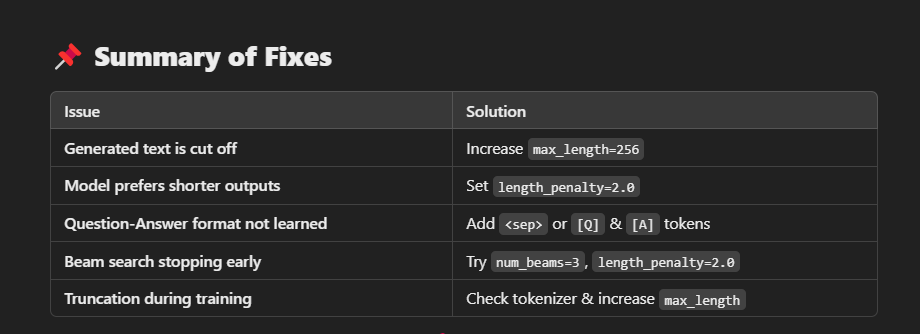

In [60]:
predictions = []
true_labels = []
contexts = []

for example in test_processed[20:40]:
    input_ids = example["input_ids"].unsqueeze(0).to(device)
    attention_mask = example["attention_mask"].unsqueeze(0).to(device)

    # Decode the input context
    context_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    contexts.append(context_text)

    # Extract the true label (ground truth)
    true_label_ids = example["labels"]
    true_label_text = tokenizer.decode(true_label_ids, skip_special_tokens=True)
    true_labels.append(true_label_text)

    # Generate prediction
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=512,
            do_sample = True,
            # num_beams=5,
            # length_penalty=2.0,  # Increase length preference
            top_p = 0.9,
            temperature = 0.7,
            num_return_sequences = 5,
            early_stopping=True
        )

    predicted_text = tokenizer.decode(output_ids[0], skip_special_tokens=True) # try False
    predictions.append(predicted_text)

# Print some sample results
for i, (context, pred, true) in enumerate(zip(contexts[:], predictions[:], true_labels[:])):
    print(f"Example {i+1}:")
    print(f"  Context (Input): {context}")
    print(f"  Prediction: {pred}")
    print(f"  Ground Truth: {true}")
    print("------------")

# Compute BLEU score
bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(true_labels, predictions)]
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f"BLEU Score: {average_bleu:.4f}")

Example 1:
  Context (Input): ناقشت اللجنة امكانية استخدام وظيفة شيفت كما هو الحال في ITA2 مما يسمح بتمثيل اكثر من 64 رمزا برمز من ست بتات في رمز شيفتيد تحدد بعض رموز الاحرف الاختيارات بين خيارات رموز الاحرف التالية وهو يسمح بتشفير مدمج ولكنه اقل موثوقية لنقل البيانات كخطا في نقل شفرة التغيير يجعل عادة جزءا طويلا من الارسال غير قابل للقراءة قررت لجنة المعايير عدم التغيير ولذلك تطلبت ASCII رمزا على الاقل من سبعة بتات 215 236 4
  Prediction: في ASCII ما هي الرموز التي يمكن تمثيلها في رمز شيفت؟
  Ground Truth: ما هو مختلف في رمز التحول
------------
Example 2:
  Context (Input): ناقشت اللجنة امكانية استخدام وظيفة شيفت كما هو الحال في ITA2 مما يسمح بتمثيل اكثر من 64 رمزا برمز من ست بتات في رمز شيفتيد تحدد بعض رموز الاحرف الاختيارات بين خيارات رموز الاحرف التالية وهو يسمح بتشفير مدمج ولكنه اقل موثوقية لنقل البيانات كخطا في نقل شفرة التغيير يجعل عادة جزءا طويلا من الارسال غير قابل للقراءة قررت لجنة المعايير عدم التغيير ولذلك تطلبت ASCII رمزا على الاقل من سبعة بتات 215 236 4
  Prediction: متى 